# Spotify song popularity prediction

by Louis Caubet, 2022. 

In [32]:
import pandas as pd
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torch import nn

import time
from math import sqrt, exp, isnan
import random
import matplotlib.pyplot as plt
import numpy as np

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

PATH_TO_DATASETS = "drive/MyDrive/datasets/"

For this project, we will use a simple dense neural network. Let's start by building it and defining training and testing functions. We will then train it with different types of preprocessing and compare the results.

## Build the neural network

Our network is a small dense network using 3 linear layers, activated with the ReLU function. We apply the sigmoid function on the output to get a result between 0 and 1, as expected.

Training is fairly standard: SGD with MSE loss function. We try to run it on CUDA if possible. 

We print the final RMSE loss as result of the testing phase. 

In [2]:
print("Running on device: " + 'cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Network(nn.Module):
  def __init__(self, number_of_inputs):
    super(Network, self).__init__()
    self.sequence = nn.Sequential(
        nn.Linear(number_of_inputs, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.sequence(x)

  def train(self, batch_size, learning_rate, epochs, dataset):
    size = len(dataset)
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)

    for epoch in range(epochs):
      for item in dataloader:
        X = item[0]
        y = item[1]
        X = X.to(device)
        y = y.to(device)
        pred = self(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()

      print("Training: epoch ", epoch+1, "/", epochs, ": loss=", sqrt(loss))

  def test_loop(self, test_dataset, loss_fn):
    dataloader = DataLoader(test_dataset, 64, shuffle=True)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
      for item in dataloader:
        X = item[0]
        y = item[1]
        X = X.to(device)
        y = y.to(device)
        pred = self(X)
        test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches

    print("Test results:")
    print("Average RMSE loss: ", sqrt(test_loss))

    return test_loss

cpu


In [3]:
def train_network(dataset_train, dataset_test, number_of_inputs):
  model = Network(number_of_inputs)
  model = model.to(device)

  print("Starting training...")
  start = time.time()

  model.train(64, 0.01, 10, dataset_train)

  print("Training complete!")
  print("Training time: " + str(time.time() - start))


  print("Starting test phase...")
  start = time.time()
  model.test_loop(dataset_test, nn.MSELoss())

  print("Testing complete!")
  print("Test time: " + str(time.time() - start))

  return model

### Setup Captum to visualize importances in the model

In [33]:
# Helper method to print importances and visualize distribution
# Source: https://captum.ai/tutorials/Titanic_Basic_Interpret
def plot_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

def visualize_importances(model, dataset, feature_names):
  ig = IntegratedGradients(model)
  dataloader = DataLoader(dataset, 64, shuffle=True)
  item = next(iter(dataloader))
  input = item[0]
  input.requires_grad_()
  attr, delta = ig.attribute(input,target=0, return_convergence_delta=True)
  attr = attr.detach().numpy()

  plot_importances(feature_names, np.mean(attr, axis=0))

## Basic approach: minimal preprocessing

### Dataset loading and preprocessing

We use the "Spotify Audio Features" dataset, available on [Kaggle](https://www.kaggle.com/tomigelo/spotify-audio-features/version/3). Download the *.csv files next to this notebook before running the next cells.

The following cell preprocesses the CSV file into a PyTorch dataset. The inputs are tensors of fields acousticness, danceability, duration, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, and valence. The output is the popularity of the song.

Note that there might be duplicates between files 1 and 2, with different outputs. This should not impact performance, as having duplicates in the training set is no big deal with neural networks, and the expected outputs, though different, should be fairly close.

These fields are normalized between 0 and 1. For key, tempo, year and popularity, we use linear normalization. I have pre-computed the extreme values for the columns where this information is needed. For loudness, we apply the sigmoid function, as a difference in loudness between -20 and -60 is way less significant than between 2 and -2.

We then randomly split the resulting dataset into train and test sets, in an 80-20 ratio.

In [35]:
class SpotifyDataset(Dataset):
  def __init__(self, audio_features):
    self.dataset = []

    for index, row in audio_features.iterrows():
      [input, output] = self.preprocess(row)
      self.dataset.append([torch.Tensor(input), torch.Tensor(output)])

  def preprocess(self, entry):
    input = [entry['acousticness'], 
             entry['danceability'],
             entry['duration_ms'] / 5610020,
             entry['energy'], 
             entry['instrumentalness'], 
             entry['key'] / 11, 
             entry['liveness'], 
             1/(1+exp(-entry['loudness'])), 
             entry['mode'],
             entry['speechiness'], 
             entry['tempo'] / 250, 
             entry['valence']] 
    
    output = [entry['popularity'] / 100]

    return [input, output]

  def __getitem__(self, index):
    return self.dataset[index]

  def __len__(self):
    return len(self.dataset)

def load_csv():
  csv1 = pd.read_csv(PATH_TO_DATASETS + "SpotifyAudioFeaturesNov2018.csv")
  csv2 = pd.read_csv(PATH_TO_DATASETS + "SpotifyAudioFeaturesApril2019.csv")
  return pd.concat([csv1, csv2])

print("Loading and preprocessing dataset...")
start = time.time()

dataset = SpotifyDataset(load_csv())
train_length = round(0.8*len(dataset))
[dataset_train, dataset_test] = random_split(dataset, [train_length, len(dataset) - train_length])

print("Dataset loading and preprocessing complete!")
print("Execution time: ", time.time() - start, "s")

Loading and preprocessing dataset...
Dataset loading and preprocessing complete!
Execution time:  44.98452925682068 s


### Run training and eval

With this preprocessing, we achieve a 0.18 RMSE loss, which is good (on average, we're at a distance of 18 of the correct popularity, rated on 100), but we can probably improve this by adding crucial parameters to our dataset.

In [27]:
model1 = train_network(dataset_train, dataset_test, 12)

Starting training...
Training: epoch  1 / 10 : loss= 0.18944967404398158
Training: epoch  2 / 10 : loss= 0.2175328589424964
Training: epoch  3 / 10 : loss= 0.20145412200193424
Training: epoch  4 / 10 : loss= 0.1732144076535831
Training: epoch  5 / 10 : loss= 0.18769136240094336
Training: epoch  6 / 10 : loss= 0.19089749902128053
Training: epoch  7 / 10 : loss= 0.22378145300508775
Training: epoch  8 / 10 : loss= 0.17380008578521963
Training: epoch  9 / 10 : loss= 0.19534770648265087
Training: epoch  10 / 10 : loss= 0.16907597599156782
Training complete!
Training time: 31.366676568984985
Starting test phase...
Test results:
Average RMSE loss:  0.18396093820753742
Testing complete!
Test time: 0.48049092292785645


### Visualize importance of parameters

Average Feature Importances
acousticness :  -0.013
danceability :  0.023
duration :  -0.000
energy :  -0.001
instrumentalness :  -0.019
key :  -0.002
liveness :  -0.001
loudness :  -0.000
mode :  -0.008
speechiness :  -0.005
tempo :  -0.001
valence :  -0.006


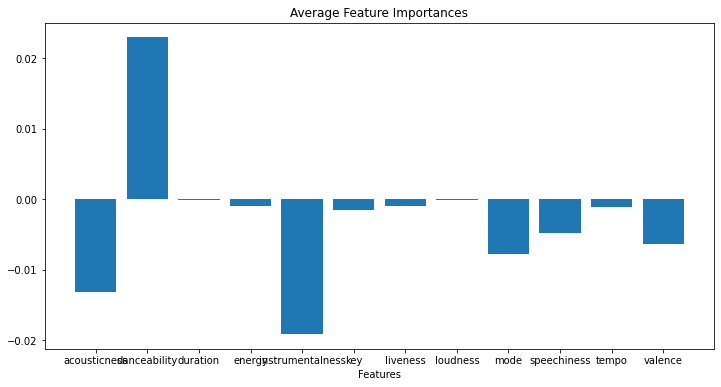

In [36]:
feature_names = ["acousticness", "danceability", "duration", "energy", 
                 "instrumentalness", "key", "liveness", "loudness", "mode",
                 "speechiness", "tempo", "valence"]
visualize_importances(model1, dataset_test, feature_names)

## Could the release date be an interesting parameter?

Intuitively, the release year of a song plays an important role in its popularity. Unfortunately, that information is not contained in the dataset. 

Luckily, another dataset, "Spotify-Data 1921-2020" on [Kaggle](https://www.kaggle.com/ektanegi/spotifydata-19212020), provides that information. Let's combine the datasets to include it!

Download the data.csv file next to this notebook before running the next cells.

In [37]:
class SpotifyDatasetWithYear(SpotifyDataset):
  def __init__(self, audio_features):
    
    audio_features = self.add_year(audio_features)

    self.years_found = 0
    self.dataset = []

    for index, row in audio_features.iterrows():
      [input, output] = self.preprocess(row)
      self.dataset.append([torch.Tensor(input), torch.Tensor(output)])

  def add_year(self, audio_features):
    spotify_data_year = pd.read_csv(PATH_TO_DATASETS + "data.csv")

    # Merge year on track id
    pd_dataframe = audio_features.merge(
      spotify_data_year[["id", "year"]], 
      left_on="track_id", 
      right_on="id", 
      how="left"
    )

    # Modify second dataset to transform list of artists into only one artist
    spotify_data_year["artists"] = spotify_data_year["artists"].apply(
      lambda x: x.split("',")[0].replace("['", "").replace("']", "")
    )

    # Merge approx year on artist name as fallback
    pd_dataframe = pd_dataframe.merge(
      spotify_data_year[["artists", "year"]].groupby("artists").mean(), 
      left_on="artist_name",
      right_on="artists", 
      how="left",
      suffixes=("_exact", "_approx")
    )

    return pd_dataframe

  def preprocess(self, entry):
    [input, output] = super().preprocess(entry)

    if not isnan(entry['year_exact']):
      input.append((entry['year_exact']-1921) / (2020-1921))
      self.years_found += 1
    elif not isnan(entry["year_approx"]):
      input.append((entry['year_approx']-1921) / (2020-1921))
      self.years_found += 1
    else:
      input.append(-1)

    return [input, output]

  def __getitem__(self, index):
    return self.dataset[index]

  def __len__(self):
    return len(self.dataset)

print("Loading and preprocessing dataset...")
start = time.time()

dataset = SpotifyDatasetWithYear(load_csv())
print("Found year information for", dataset.years_found / len(dataset) * 100, "% of entries")
train_length = round(0.8*len(dataset))
[dataset_train, dataset_test] = random_split(dataset, [train_length, len(dataset) - train_length])

print("Dataset loading and preprocessing complete!")
print("Execution time: ", time.time() - start, "s")

Loading and preprocessing dataset...
Found year information for 34.6869876738114 % of entries
Dataset loading and preprocessing complete!
Execution time:  50.07131338119507 s


In [38]:
model2 = train_network(dataset_train, dataset_test, 13)

Starting training...
Training: epoch  1 / 10 : loss= 0.18414454322048257
Training: epoch  2 / 10 : loss= 0.16609062295950408
Training: epoch  3 / 10 : loss= 0.14631969095619815
Training: epoch  4 / 10 : loss= 0.16893683395720172
Training: epoch  5 / 10 : loss= 0.17077509107242458
Training: epoch  6 / 10 : loss= 0.1592153614533399
Training: epoch  7 / 10 : loss= 0.18083828953537467
Training: epoch  8 / 10 : loss= 0.1763291033733303
Training: epoch  9 / 10 : loss= 0.16731825443777376
Training: epoch  10 / 10 : loss= 0.14177531401593219
Training complete!
Training time: 29.995652437210083
Starting test phase...
Test results:
Average RMSE loss:  0.16924664480835466
Testing complete!
Test time: 0.4078481197357178


And... we can only notice a small improvement. (0.17 compared to the previous 0.18). The release date information is therefore relevant, but it's not THE major parameter we're looking for. The fact that we could only retrieve date information for a third of the entries surely doesn't help.

### Visualize importances

Average Feature Importances
acousticness :  -0.024
danceability :  0.020
duration :  0.001
energy :  0.022
instrumentalness :  -0.014
key :  -0.001
liveness :  -0.008
loudness :  0.000
mode :  -0.012
speechiness :  -0.002
tempo :  -0.000
valence :  -0.019
year :  -0.017


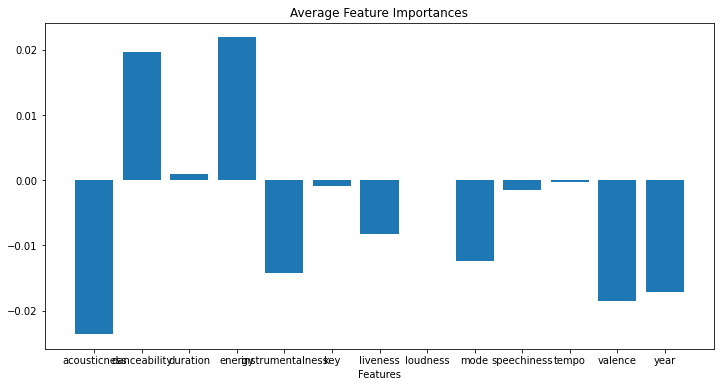

In [39]:
feature_names = ["acousticness", "danceability", "duration", "energy", 
                 "instrumentalness", "key", "liveness", "loudness", "mode",
                 "speechiness", "tempo", "valence", "year"]
visualize_importances(model2, dataset_test, feature_names)

## And what about the artist?

In the music world, once you've made a name for yourself, all your songs will probably be at least slightly popular. If you want to predict the popularity of a song from this dataset, you would definitely consider the artist, and predict a higher popularity for an Ariana Grande song than some unknown artist, all other things equal.

We need to give a way to our model to take that into account. If we directly gave the artist name to the network, it wouldn't be able to learn from it, as there is no pattern in popular artist's name... So let's start by computing an expected popularity for an artist from the information contained in the training dataset (the average popularity of their songs). Then we'll give that information to the network.

In [41]:
artist_popularities = None

class SpotifyDatasetWithArtist(SpotifyDataset):
  def __init__(self, audio_features, is_train):

    # If this is the training dataset, compute artist popularities and store it
    # in the global variable. Otherwise, retrieve that global variable to merge 
    # it with our audio features.
    global artist_popularities
    if is_train:
      artist_popularities = audio_features[["artist_name", "popularity"]].groupby("artist_name").mean()

    audio_features = audio_features.merge(
      artist_popularities, 
      left_on="artist_name", 
      right_on="artist_name", 
      how="left",
      suffixes=("", "_artist")
    )

    self.dataset = []
    self.tracks_with_unknown_artist = 0

    for index, row in audio_features.iterrows():
      self.dataset.append(self.preprocess(row))

  def preprocess(self, entry):
    [input, output] = super().preprocess(entry)

    if not isnan(entry['popularity_artist']):
      input.append(entry['popularity_artist'] / 100)
    else:
      # Why 0?
      # If an artist is unknown in the training set, we could expect them to be
      # less popular... 
      input.append(0)
      self.tracks_with_unknown_artist+=1

    return [torch.Tensor(input), torch.Tensor(output), entry["artist_name"]]

  def __getitem__(self, index):
    return self.dataset[index]

  def __len__(self):
    return len(self.dataset)

print("Loading and preprocessing dataset...")
start = time.time()

audio_features = load_csv()

# Do the train-test split using pandas
# We have to do it that way to be able to use pandas powerful features to
# compute artist's mean popularity in the training dataset
audio_features_train = audio_features.sample(frac=0.8)
audio_features_test = audio_features.drop(audio_features_train.index)

dataset_train = SpotifyDatasetWithArtist(audio_features_train, True)
dataset_test = SpotifyDatasetWithArtist(audio_features_test, False)

print("Tracks of the test set with artist unknown:", 
  dataset_test.tracks_with_unknown_artist, "of", len(dataset_test))

print("Dataset loading and preprocessing complete!")
print("Execution time: ", time.time() - start, "s")

Loading and preprocessing dataset...
Tracks of the test set with artist unknown: 441 of 12286
Dataset loading and preprocessing complete!
Execution time:  42.16477012634277 s


In [42]:
model3 = train_network(dataset_train, dataset_test, 13)

Starting training...
Training: epoch  1 / 10 : loss= 0.19746461595076648
Training: epoch  2 / 10 : loss= 0.14203206752420117
Training: epoch  3 / 10 : loss= 0.18419510179177453
Training: epoch  4 / 10 : loss= 0.15780196721270387
Training: epoch  5 / 10 : loss= 0.16478188357167203
Training: epoch  6 / 10 : loss= 0.15327627922498652
Training: epoch  7 / 10 : loss= 0.14444242144799757
Training: epoch  8 / 10 : loss= 0.09787890324507141
Training: epoch  9 / 10 : loss= 0.08290578237528223
Training: epoch  10 / 10 : loss= 0.08319882406392494
Training complete!
Training time: 28.89960217475891
Starting test phase...
Test results:
Average RMSE loss:  0.11747234793062132
Testing complete!
Test time: 0.0924828052520752


And the improvement is significant! Using the information on the artist, we got from 0.17 down to 0.11 mean error!

You can use the cell below to save the model, and the cell in "A few examples" to visualize a few predictions of the network.

In [ ]:
print("Saving model...")
torch.save(model3.state_dict(), 'model_weights.pth')
print("Model saved!")

Saving model...
Model saved!


### Visualize importances

Average Feature Importances
acousticness :  0.005
danceability :  0.013
duration :  0.001
energy :  0.017
instrumentalness :  -0.004
key :  -0.004
liveness :  -0.007
loudness :  -0.000
mode :  -0.001
speechiness :  -0.007
tempo :  -0.016
valence :  -0.011
artist popularity :  0.218


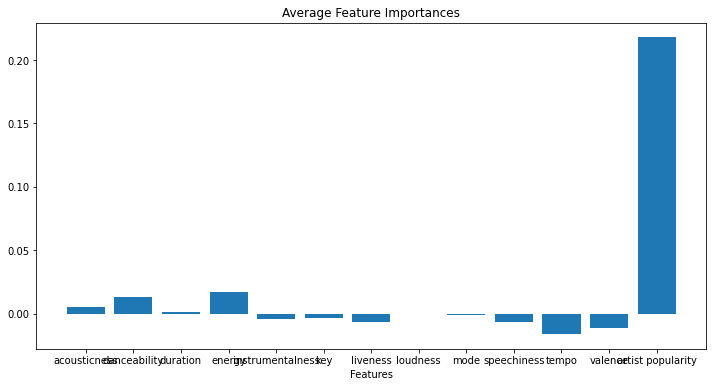

In [43]:
feature_names = ["acousticness", "danceability", "duration", "energy", 
                 "instrumentalness", "key", "liveness", "loudness", "mode",
                 "speechiness", "tempo", "valence", "artist popularity"]
visualize_importances(model3, dataset_test, feature_names)

As expected, the artist's popularity is the most heavily correlated parameter, 10x more than audio features. 

## Would using both year and artist improve this further?

While the results obtained above are already great, this is a natural question to ask!

In [9]:
artist_popularities = None

class SpotifyDatasetWithArtistAndYear(SpotifyDatasetWithYear):
  def __init__(self, audio_features, is_train):

    audio_features = self.add_year(audio_features)
    self.years_found = 0

    # If this is the training dataset, compute artist popularities and store it
    # in the global variable. Otherwise, retrieve that global variable to merge 
    # it with our audio features.
    global artist_popularities
    if is_train:
      artist_popularities = audio_features[["artist_name", "popularity"]].groupby("artist_name").mean()

    audio_features = audio_features.merge(
      artist_popularities, 
      left_on="artist_name", 
      right_on="artist_name", 
      how="left",
      suffixes=("", "_artist")
    )

    self.dataset = []
    self.tracks_with_unknown_artist = 0

    for index, row in audio_features.iterrows():
      self.dataset.append(self.preprocess(row))

  def preprocess(self, entry):
    [input, output] = super().preprocess(entry)

    if not isnan(entry['popularity_artist']):
      input.append(entry['popularity_artist'] / 100)
    else:
      # Why 0?
      # If an artist is unknown in the training set, we could expect them to be
      # less popular... 
      input.append(0)
      self.tracks_with_unknown_artist+=1

    return [torch.Tensor(input), torch.Tensor(output), entry["artist_name"]]

  def __getitem__(self, index):
    return self.dataset[index]

  def __len__(self):
    return len(self.dataset)

print("Loading and preprocessing dataset...")
start = time.time()

audio_features = load_csv()

# Do the train-test split using pandas
# We have to do it that way to be able to use pandas powerful features to
# compute artist's mean popularity in the training dataset
audio_features_train = audio_features.sample(frac=0.8)
audio_features_test = audio_features.drop(audio_features_train.index)

dataset_train = SpotifyDatasetWithArtistAndYear(audio_features_train, True)
dataset_test = SpotifyDatasetWithArtistAndYear(audio_features_test, False)

print("Retrieved year data for", dataset_train.years_found / len(dataset_train) * 100,
      "% of the training dataset, and", dataset_test.years_found / len(dataset_test) * 100,
      "% of the test dataset")

print("Tracks of the test set with artist unknown:", 
  dataset_test.tracks_with_unknown_artist, "of", len(dataset_test))

print("Dataset loading and preprocessing complete!")
print("Execution time: ", time.time() - start, "s")

Loading and preprocessing dataset...
Retrieved year data for 34.72382455927298 % of the training dataset, and 42.012753433616744 % of the test dataset
Tracks of the test set with artist unknown: 438 of 12232
Dataset loading and preprocessing complete!
Execution time:  48.397501707077026 s


In [10]:
model4 = train_network(dataset_train, dataset_test, 14)

Starting training...
Training: epoch  1 / 10 : loss= 0.18818416545882036
Training: epoch  2 / 10 : loss= 0.17631355855908648
Training: epoch  3 / 10 : loss= 0.14655721760647208
Training: epoch  4 / 10 : loss= 0.16368080196754092
Training: epoch  5 / 10 : loss= 0.13126815460305075
Training: epoch  6 / 10 : loss= 0.11080449334618238
Training: epoch  7 / 10 : loss= 0.10236072472311483
Training: epoch  8 / 10 : loss= 0.08858015004815942
Training: epoch  9 / 10 : loss= 0.08913460518940625
Training: epoch  10 / 10 : loss= 0.1292041890059825
Training complete!
Training time: 27.284608840942383
Starting test phase...
Test results:
Average RMSE loss:  0.11774557171154766
Testing complete!
Test time: 0.09087848663330078


It appears that using both year and artist does not lead to any improvement compared to only using artist. We couldn't have expected much from this anyway, as the improvement was small when adding just the year, and that we already achieved great results with just the artist information.

## A few examples

In [ ]:
NB_EXAMPLES = 5
for i in range(NB_EXAMPLES):
  index = random.randint(0, len(dataset_test)-1)
  [input, output, _] = dataset_test.__getitem__(index)
  pred = model(input)
  print("Input", index)
  print("Expected:", output.item()*100)
  print("Predicted:", pred.item()*100)
  print("Error:", abs(output.item()-pred.item())*100)
  print()

Input 10416
Expected: 57.999998331069946
Predicted: 32.72614777088165
Error: 25.273850560188293

Input 6161
Expected: 0.0
Predicted: 6.9739095866680145
Error: 6.9739095866680145

Input 5216
Expected: 33.000001311302185
Predicted: 15.847137570381165
Error: 17.15286374092102

Input 10875
Expected: 70.99999785423279
Predicted: 64.03908133506775
Error: 6.960916519165039

Input 9471
Expected: 3.999999910593033
Predicted: 9.040670841932297
Error: 5.040670931339264

